# **Configuration**

In [1]:
import os
import random
import numpy as np
import tensorflow as tf

def configure_gpu(device_id: str = "0") -> None:
    """
    Configures the GPU for TensorFlow usage.

    Parameters:
    - device_id (str): The GPU device ID to use. Default is "0".

    Returns:
    - None: Prints TensorFlow version and GPU availability.
    """
    os.environ["CUDA_VISIBLE_DEVICES"] = device_id

    print(f'TensorFlow Version: {tf.__version__}')

    if tf.config.list_physical_devices('GPU'):
        print('GPU detected and configured!')
    else:
        print('No GPU found, using CPU.')

def set_random_seed(seed_value: int = 42) -> None:
    """
    Sets a fixed seed for random number generation to ensure reproducibility.

    Parameters:
    - seed_value (int): The seed value to set. Default is 42.

    Returns:
    - None: Prints confirmation of seed initialization.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

    print(f'Random seed initialized to {seed_value}.')

# Initialize seed and device configuration
set_random_seed()
configure_gpu()

Done!


# **Import**

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from modules.tfkan.layers import DenseKAN
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model, Model
from livelossplot.inputs.tf_keras import PlotLossesCallback

# **Data Loader**

In [4]:
bins_num = 10
data_num = 20000
data_length = 3000


def generate_data(data_num, data_length):
    inputs = np.random.rand(1, data_length)
    coeffs = np.random.rand(data_num, 1)
    additions = np.random.rand(data_num, 1)

    return pd.DataFrame(np.abs(np.sin(np.dot(coeffs, inputs) + additions)))


dataset = generate_data(data_num, data_length)

In [6]:
def get_shannon_entropy(dists: np.array):
    epsilon = 1e-10
    dists = np.clip(dists, epsilon, 1)
    return -np.sum(dists * np.log(dists), axis=1)


def get_dist(data: pd.DataFrame, bins: np.array):
    dist, _ = np.histogram(data, bins=bins, density=True)
    dist = dist / np.sum(dist)
    return dist


bins = np.linspace(0, 1, bins_num + 1)
dists = np.array([get_dist(dataset.iloc[i], bins) for i in range(data_num)])
y_sin = get_shannon_entropy(dists)

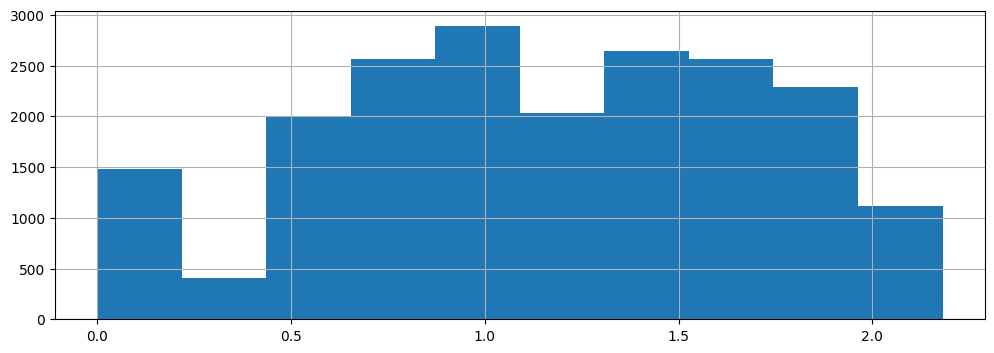

In [7]:
plt.figure(figsize=(12, 4))
plt.hist(y_sin)
plt.grid()
plt.show()

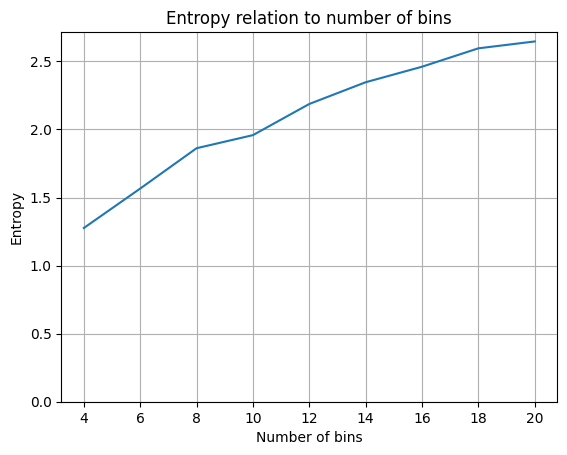

In [8]:
data_sample = dataset[5:6]

bins_counts = np.arange(4, 21, 2)
dists = []
entropies = []

# Calculate
for bin_count in bins_counts:
    bin_values = np.linspace(0, 1, bin_count + 1)
    dists = np.array([get_dist(data_sample.iloc[i], bin_values) for i in range(len(data_sample))])
    entropies.append(get_shannon_entropy(dists))

# Plot
plt.figure()
plt.grid()
plt.title("Entropy relation to number of bins")
plt.xlabel("Number of bins")
plt.ylabel("Entropy")
plt.plot(bins_counts, entropies)
plt.ylim(0)
plt.show()

# **Initialization**

In [9]:
# Pre-training parameters
pre_num_epochs = 10
pre_batch_size = 2
shape = (3000, 1)
pre_lr = 0.001
pre_opt = tf.keras.optimizers.Adamax(learning_rate=pre_lr)
pre_los = tf.keras.losses.MeanSquaredError()
pre_mtr = []

# **Data preparation**

In [10]:
X_train = dataset.sample(frac=0.8, random_state=1)
X_test = dataset.drop(X_train.index)

y_train = y_sin[X_train.index]
y_test = y_sin[X_test.index]

# **Model**

In [11]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [12]:
def build_model(input_shape,
                head_size,
                num_heads,
                ff_dim,
                num_transformer_blocks,
                dropout=0):
    inputs = layers.Input(shape=input_shape)

    x = inputs

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.Flatten()(x)

    fc = DenseKAN(32)(x)
    fc = DenseKAN(10)(fc)
    outputs = layers.Softmax()(fc)

    epsilon = tf.constant(1e-10, dtype=outputs.dtype)
    dists = tf.clip_by_value(outputs, epsilon, 1.0)
    entropy = -tf.reduce_sum(dists * tf.math.log(dists), axis=1)

    return Model(inputs, entropy)


pre_model = build_model(input_shape=shape, head_size=256, num_heads=8, ff_dim=8, num_transformer_blocks=8)
pre_model.compile(optimizer=pre_opt, loss=pre_los, metrics=pre_mtr)
pre_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3000, 1)]    0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 3000, 1)     14337       ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 3000, 1)      0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 3000, 1)     2           ['dropout[0][0]']            

# **Train**

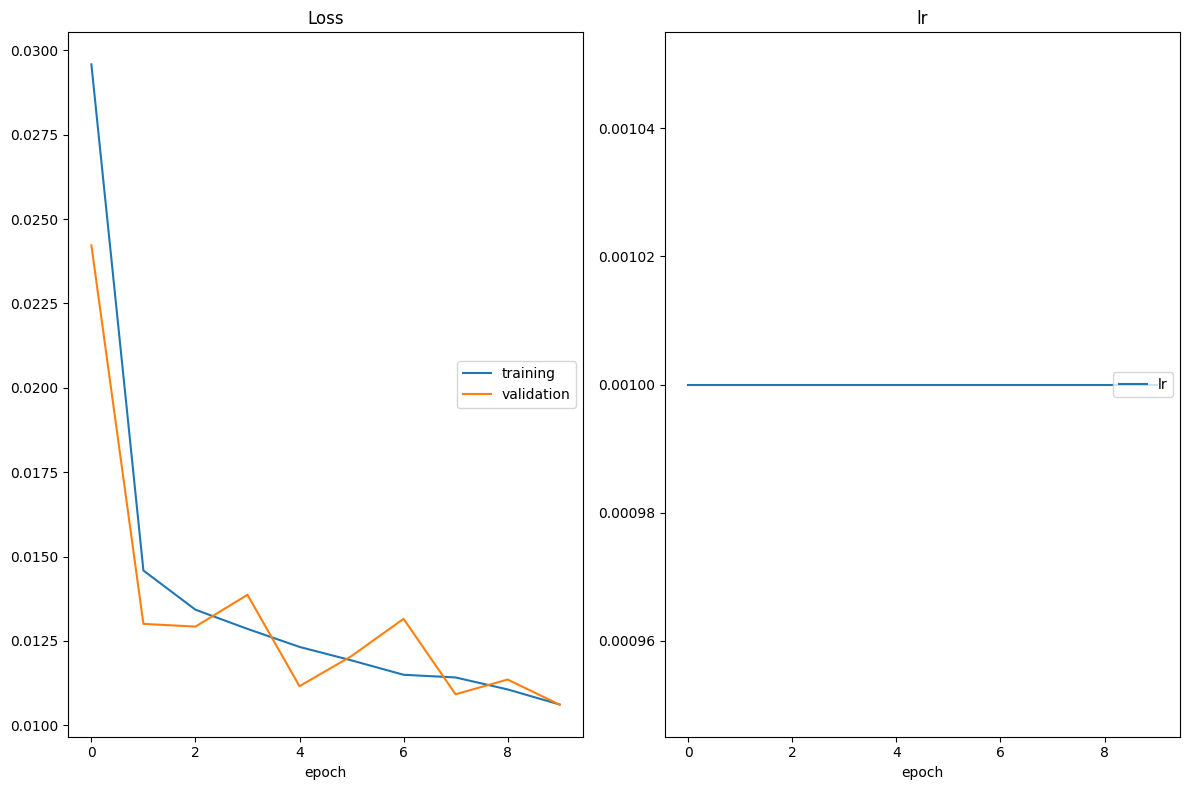

Loss
	training         	 (min:    0.011, max:    0.030, cur:    0.011)
	validation       	 (min:    0.011, max:    0.024, cur:    0.011)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
8000/8000 [==============================] - 5577s 697ms/step - loss: 0.0106 - val_loss: 0.0106 - lr: 0.0010


In [13]:
def pre_callbacks():
    chk = ModelCheckpoint(filepath="../models/shannon_entropy", 
                          monitor='val_loss', 
                          mode='min',
                          verbose=1,
                          save_best_only=True)
    rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                               factor=0.5, 
                                               patience=3, 
                                               min_lr=0.0001)
    vk = PlotLossesCallback()
    return [chk, rlr, vk]


pre_history = pre_model.fit(X_train,
                            y_train,
                            validation_data=(X_test, y_test),
                            batch_size=pre_batch_size,
                            epochs=pre_num_epochs,
                            verbose=1,
                            callbacks=pre_callbacks(),
                            steps_per_epoch=len(y_train) // pre_batch_size,
                            validation_steps=len(y_test) // pre_batch_size)

# **Evaluation**

In [14]:
pre_model = load_model("../models/shannon_entropy")

In [15]:
dists = np.array([get_dist(pd.DataFrame(X_test.iloc[i]), bins) for i in range(len(X_test))])
y_true = get_shannon_entropy(dists)

X_test_reshaped = np.expand_dims(X_test.values, axis=-1)

y_pred = []
for test_data in X_test_reshaped:
  y_pred.append(pre_model.predict(test_data.reshape(1, 3000, 1)))

1/1 [==============================] - 0s 9ms/step


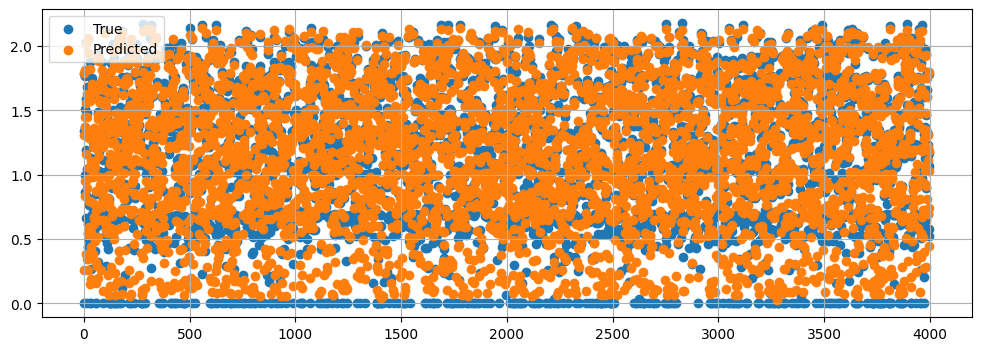

In [16]:
x_axis = np.arange(len(y_true))
plt.figure(figsize=(12, 4))
plt.scatter(x_axis, y_true, label='True')
plt.scatter(x_axis, y_pred, label='Predicted')
plt.grid()
plt.legend()
plt.show()

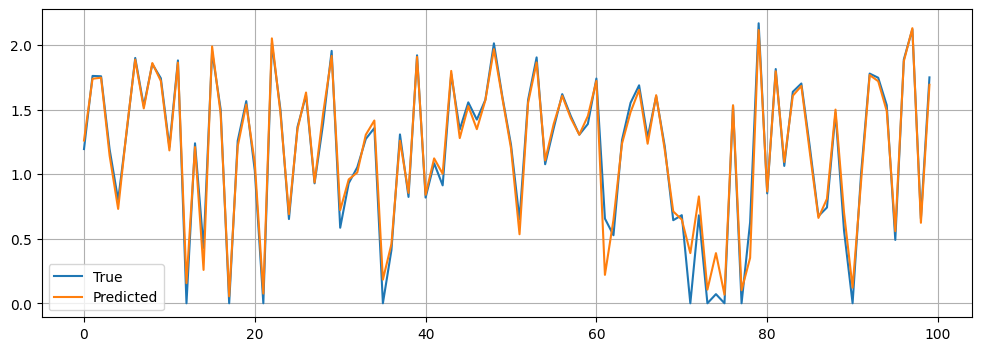

In [17]:
y_true_sample = y_true[200:300]
y_pred_sample = y_pred[200:300]

plt.figure(figsize=(12, 4))
plt.plot(y_true_sample, label='True')
plt.plot(y_pred_sample, label='Predicted')
plt.grid()
plt.legend()
plt.show()